In [1]:
pip install tensorflow python-dotenv pandas numpy scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Import Necessary Libraries

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

## Load Data

In [3]:
load_dotenv()  # Load environment variables from .env file
jwt_token = os.getenv('JWT_TOKEN')

headers = {'Authorization': f'Bearer {jwt_token}'}

api_urls = {
    'interactions': 'http://161.97.109.65:3000/api/interactions',
    'users': 'http://161.97.109.65:3000/api/users',
    'products': 'http://161.97.109.65:3000/api/products'
}

def fetch_data(url, headers):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raises an HTTPError for bad requests
        data = pd.DataFrame(response.json())
        print(f"Data successfully fetched from {url}")
        print(data.head())  # Display the first few rows of the DataFrame
        return data
    except requests.RequestException as e:
        print(f'Failed to fetch data from {url}: {str(e)}')
        return pd.DataFrame()

# Fetch data from APIs
users = fetch_data(api_urls['users'], headers)
products = fetch_data(api_urls['products'], headers)
interactions = fetch_data(api_urls['interactions'], headers)

# Check if data was fetched successfully
if not users.empty and not products.empty and not interactions.empty:
    print("All data fetched successfully.")
else:
    print("Data fetching failed, check errors and retry.")
    # Optionally, add logic to halt further processing if data is crucial


Data successfully fetched from http://161.97.109.65:3000/api/users
                        _id       firstname       lastname         username  \
0  6665e9847aa0dfec0ad43b26         Machine       Learning  machinelearning   
1  6665eab57aa0dfec0ad43b2a  DummyFirstname  DummyLastname       dummydata1   
2  6665eac87aa0dfec0ad43b2d  DummyFirstname  DummyLastname       dummydata2   
3  6665eacc7aa0dfec0ad43b30  DummyFirstname  DummyLastname       dummydata3   
4  6665eacf7aa0dfec0ad43b33  DummyFirstname  DummyLastname       dummydata4   

                  email         phone  \
0          ml@admin.com    7777777777   
1  dummydata1@admin.com  777777770001   
2  dummydata2@admin.com  777777770002   
3  dummydata3@admin.com  777777770003   
4  dummydata4@admin.com  777777770004   

                                            password           address  \
0  $2a$10$oNSoSQcmxvHAefk5dKx0UuJw8oSdGeCumA.ZqIN...  Bangkit Capstone   
1  $2a$10$ihldsbescWBR9v94/sRhReBpX8mZMGrRpwkUohU...   Dummy Ad

## Data Preprocessing

In [4]:
# Let's assume 'interactions' is a DataFrame with a column containing dictionaries
# First, ensure that the 'interactions' column is appropriately normalized
if 'interactions' in interactions.columns:
    interactions_expanded = pd.json_normalize(interactions['interactions'])
else:
    interactions_expanded = pd.json_normalize(interactions.iloc[:, 0])  # If 'interactions' is the name of DataFrame and not a column

# Assuming the JSON data has keys 'userId', 'productId', and 'interactionValue'
interactions_expanded['user_id'] = interactions_expanded['userId']
interactions_expanded['product_id'] = interactions_expanded['productId']
interactions_expanded['interaction_value'] = interactions_expanded['interactionValue']

# Encode user_id and product_id
user_ids = interactions_expanded['user_id'].unique().tolist()
product_ids = interactions_expanded['product_id'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
productencoded2product = {i: x for i, x in enumerate(product_ids)}

interactions_expanded['user'] = interactions_expanded['user_id'].map(user2user_encoded)
interactions_expanded['product'] = interactions_expanded['product_id'].map(product2product_encoded)

# Split the data
train, test = train_test_split(interactions_expanded, test_size=0.2, random_state=42)

# Convert data into required format
x_train = [train['user'].values, train['product'].values]
y_train = train['interaction_value'].values
x_test = [test['user'].values, test['product'].values]
y_test = test['interaction_value'].values

## Define Model

In [5]:
user_input = Input(shape=(1,))
user_embedding = Embedding(len(user2user_encoded), 50)(user_input)  # Removed input_length
user_vec = Flatten()(user_embedding)

product_input = Input(shape=(1,))
product_embedding = Embedding(len(product2product_encoded), 50)(product_input)  # Removed input_length
product_vec = Flatten()(product_embedding)

dot_product = Dot(axes=1)([user_vec, product_vec])
dense = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(dot_product)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
output = Dense(1)(dense)

model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(), loss='mean_squared_error')

## Train Model

In [6]:
# Assuming 'train' and 'test' datasets are already split and preprocessed
x_train = [np.array(train['user']), np.array(train['product'])]
y_train = np.array(train['interaction_value'])

# Early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model.fit(x_train, y_train, epochs=100, verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Optionally, you can add callbacks, for example to save the best model or early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path to the model directory
model_dir = os.path.join('..', 'model', 'collaborative_model.keras')

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 12.9007 - val_loss: 9.3518 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.6524 - val_loss: 8.3326 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4040 - val_loss: 7.4671 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2768 - val_loss: 6.8027 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6364 - val_loss: 6.1842 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8738 - val_loss: 5.7241 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5018 - val_loss: 5.4220 - learning_rate: 0.0010
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1259 - val_loss: 5.1876 - learning_rate: 0.0010
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8011 - val_loss: 5.0207 - learning_rate: 0.0010
Epoch 10/100
40/

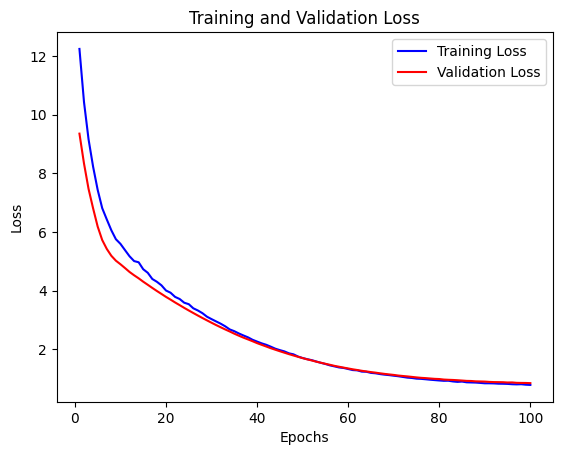

In [7]:
# Get training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss history
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Try Model

In [8]:
# Function to get recommendations for a specific user
def recommend_products(user_id, model, interactions, user2user_encoded, product2product_encoded, productencoded2product, products, top_n=30):
    # Check if user_id is in the encoding map
    if user_id not in user2user_encoded:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_encoded = user2user_encoded[user_id]
    # Get all encoded product IDs as a list of integers
    product_ids = list(product2product_encoded.values())

    # Create user-product array for prediction
    # Ensure all entries are integers for the model input
    user_product_array = np.array([[user_encoded] * len(product_ids), product_ids]).T.astype(int)

    # Predict interaction values using the model
    predictions = model.predict([user_product_array[:, 0], user_product_array[:, 1]])
    predictions = predictions.flatten()

    # Get top N product indices
    top_indices = predictions.argsort()[-top_n:][::-1]
    # Decode the top indices to product IDs
    recommended_product_ids = [productencoded2product[x] for x in top_indices]
 
    # Filter the products DataFrame to get recommended products using the correct column name
    recommended_products = products[products['_id'].isin(recommended_product_ids)]
    return recommended_products

# Try the model with the specified user ID
user_id = '6665e9847aa0dfec0ad43b26'
recommended_products = recommend_products(user_id, model, interactions, user2user_encoded, product2product_encoded, productencoded2product, products)
print(f"Recommended products for user {user_id}:")
print(recommended_products)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Recommended products for user 6665e9847aa0dfec0ad43b26:
                           _id     category     price  \
25    6667ef73b3e75416b2fa7e4c         Meja  103175.0   
42    6667ef73b3e75416b2fa7e5d         Meja  109000.0   
96    6667ef73b3e75416b2fa7e93         Meja  147000.0   
174   6667ef73b3e75416b2fa7ee1         Meja  120000.0   
177   6667ef73b3e75416b2fa7ee4         Meja  196700.0   
236   6667ef73b3e75416b2fa7f1f         Meja  167310.0   
250   6667ef73b3e75416b2fa7f2d         Meja   15900.0   
296   6667ef73b3e75416b2fa7f5b        Kasur  149500.0   
317   6667ef73b3e75416b2fa7f70        Kasur   98000.0   
426   6667ef73b3e75416b2fa7fdd  Kipas Angin   57000.0   
429   6667ef73b3e75416b2fa7fe0  Kipas Angin  118275.0   
449   6667ef73b3e75416b2fa7ff4  Kipas Angin  218000.0   
490   6667ef73b3e75416b2fa801d  Kipas Angin  129900.0   
509   6667ef73b3e75416b2fa8030  Kipas Angin   36000.0   
594   6667ef73b3e75416b2fa8085  Kipas Angin   9500

In [10]:
# Save model
model_path = os.path.join('../config', 'kelas_config.json')
model_json = model.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_json)

# Save model weights in HDF5 format
weights_path = os.path.join('../weights', 'kelas_model.weights.h5')
model.save_weights(weights_path)

In [11]:
# Load model & weights
model_path = os.path.join('../config', 'kelas_config.json')
with open(model_path, "r") as json_file:
    loaded_model_json = json_file.read()

model1 = tf.keras.models.model_from_json(loaded_model_json)
model1.load_weights(os.path.join('../weights', 'kelas_model.weights.h5'))

# Compile loaded model
model1.compile(optimizer='rmsprop', loss='mean_squared_error')

In [12]:
# Function to get recommendations for a specific user
def recommend_products(user_id, model, interactions, user2user_encoded, product2product_encoded, productencoded2product, products, top_n=30):
    # Check if user_id is in the encoding map
    if user_id not in user2user_encoded:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_encoded = user2user_encoded[user_id]
    # Get all encoded product IDs as a list of integers
    product_ids = list(product2product_encoded.values())

    # Create user-product array for prediction
    # Ensure all entries are integers for the model input
    user_product_array = np.array([[user_encoded] * len(product_ids), product_ids]).T.astype(int)

    # Predict interaction values using the model
    predictions = model.predict([user_product_array[:, 0], user_product_array[:, 1]])
    predictions = predictions.flatten()

    # Get top N product indices
    top_indices = predictions.argsort()[-top_n:][::-1]
    # Decode the top indices to product IDs
    recommended_product_ids = [productencoded2product[x] for x in top_indices]
 
    # Filter the products DataFrame to get recommended products using the correct column name
    recommended_products = products[products['_id'].isin(recommended_product_ids)]
    return recommended_products

# Try the model with the specified user ID
user_id = '6665eacf7aa0dfec0ad43b33'
recommended_products = recommend_products(user_id, model1, interactions, user2user_encoded, product2product_encoded, productencoded2product, products)
print(f"Recommended products for user {user_id}:")
print(recommended_products)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Recommended products for user 6665eacf7aa0dfec0ad43b33:
                           _id     category      price  \
6     6667ef73b3e75416b2fa7e39         Meja    39500.0   
15    6667ef73b3e75416b2fa7e42         Meja    46500.0   
31    6667ef73b3e75416b2fa7e52         Meja   114900.0   
56    6667ef73b3e75416b2fa7e6b         Meja    98500.0   
70    6667ef73b3e75416b2fa7e79         Meja    70200.0   
183   6667ef73b3e75416b2fa7eea         Meja   121987.0   
244   6667ef73b3e75416b2fa7f27         Meja   369000.0   
319   6667ef73b3e75416b2fa7f72        Kasur  3299000.0   
356   6667ef73b3e75416b2fa7f97        Kasur   224000.0   
369   6667ef73b3e75416b2fa7fa4        Kasur   242500.0   
416   6667ef73b3e75416b2fa7fd3        Kasur    77500.0   
462   6667ef73b3e75416b2fa8001  Kipas Angin    50500.0   
474   6667ef73b3e75416b2fa800d  Kipas Angin    80000.0   
515   6667ef73b3e75416b2fa8036  Kipas Angin   175000.0   
539   6667ef73b3e75416b2fa804e  Kip